# Part 1: Text Processing and Exploratory Data Analysis

In [ ]:
#Imports
from collections import defaultdict
from array import array
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import re
import pandas as pd
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy


nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading the data

In [ ]:
#Import and mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/Shareddrives/IRWA/IRWA_data_2023/Rus_Ukr_war_data.json"
data_ids_path = "/content/drive/Shareddrives/IRWA/IRWA_data_2023/Rus_Ukr_war_data_ids.csv"

#First we will load the data
with open(data_path) as fp:
    lines = fp.readlines()

tweets = [json.loads(line) for line in lines]

#Next we will load the ids into a map
with open(data_ids_path) as fp:
    lines = fp.readlines()

tweet_document_ids_map = { line.split()[0]: line.split()[1] for line in lines}

## Cleaning the data

### Preprocessing

As a first step, you must pre-process the documents by
* Removing stop words
* Tokenization
* Removing punctuation marks
* Stemming
* and... anything else you think it's needed (bonus point)

In [ ]:
def remove_emojis(text):
    """
    Remove all emojis from the given text

    Argument:
    text -- the text to clean

    Returns:
    text - the same text without emojis
    """

    #All emojis are represented in Unicode, so we can remove them by using RE
    #Regular expression found at https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    emojis_expression = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642"
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                            "]+", flags=re.UNICODE)

    return re.sub(emojis_expression, "", text)

def preprocess(text):
    """
    Clean and tokenize the text

    Argument:
    text -- the text to clean

    Returns:
    text - the list of tokens obtained from the input text.
    """
    stemmer = PorterStemmer()
    stop_words = stopwords.words("english")
    punctuation = r"[!¡?¿.:,;()\[\]{}\-\'\"]"

    text = remove_emojis(text) #Remove emojis
    text = text.strip() #Remove whitespaces at the beginning and at the end
    text = text.lower() ## Transform in lowercase
    text = re.sub(punctuation, "", text) ## Eliminate puntuation marks
    text = text.split() ## Tokenize the text to get a list of terms
    text = [token for token in text if token not in stop_words] ## Eliminate the stopwords
    text = [stemmer.stem(token) for token in text] ## Perform stemming

    return text


print(preprocess(tweets[0]["full_text"]))

['@melsimmonsfcdo', 'wrong', 'dictat', 'putin', 'fascist', 'russia', 'intend', 'conquer', 'much', 'ukrainian', 'land', 'possibl', '#russiainvadesukrain', '#ukrainerussiawar']


### Loading the data into the dataframe

In [ ]:
#transform json text to dataset
df = pd.read_json(data_path, lines=True )
#display(df)

In [ ]:
#select the desired columns
df_clean = df[['created_at', 'full_text', 'id_str', 'entities', 'favorite_count', 'user', 'retweet_count', 'lang']]
display(df_clean)

,created_at,full_text,id_str,entities,favorite_count,user,retweet_count,lang
0,2022-09-30 18:39:17+00:00,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,1575918221013979136,"{'hashtags': [{'text': 'RussiainvadesUkraine',...",0,"{'id': 1404526426330701825, 'id_str': '1404526...",0,en
1,2022-09-30 18:38:44+00:00,🇺🇦❤️ The Armed Forces liberated the village of...,1575918081461080064,"{'hashtags': [{'text': 'Drobysheve', 'indices'...",0,"{'id': 1257116113898536961, 'id_str': '1257116...",0,en
2,2022-09-30 18:38:23+00:00,ALERT 🚨Poland preps anti-radiation tablets ove...,1575917992390823936,"{'hashtags': [{'text': 'NATO', 'indices': [64,...",0,"{'id': 1460003892415053828, 'id_str': '1460003...",0,en
3,2022-09-30 18:38:03+00:00,I’m still waiting for my google map 🗺️ to upda...,1575917907774967808,"{'hashtags': [{'text': 'Putin', 'indices': [12...",0,"{'id': 285766081, 'id_str': '285766081', 'name...",0,en
4,2022-09-30 18:37:56+00:00,@EmmanuelMacron probably you're right or you h...,1575917878410301440,"{'hashtags': [{'text': 'European', 'indices': ...",0,"{'id': 1537193346107686915, 'id_str': '1537193...",0,en
...,...,...,...,...,...,...,...,...
3995,2022-09-28 16:05:00+00:00,🎥 Ukraine’s president has warned that Russia’s...,1575154617620504576,"{'hashtags': [{'text': 'UkraineRussiaWar', 'in...",4,"{'id': 330255896, 'id_str': '330255896', 'name...",1,en
3996,2022-09-28 16:04:19+00:00,Germany amusingly shares days old intelligense...,1575154444165156864,"{'hashtags': [{'text': 'germany', 'indices': [...",0,"{'id': 88797142, 'id_str': '88797142', 'name':...",0,en
3997,2022-09-28 16:04:18+00:00,The US Embassy in Moscow is urging Americans t...,1575154440012812288,"{'hashtags': [{'text': 'fakenewsfilter', 'indi...",0,"{'id': 3387837064, 'id_str': '3387837064', 'na...",0,en
3998,2022-09-28 16:03:56+00:00,After the staged fake referendum as of Septemb...,1575154351273873408,"{'hashtags': [{'text': 'UkraineRussiaWar', 'in...",13,"{'id': 921511082128232450, 'id_str': '92151108...",2,en


### Adding new columns to the dataframe

In [ ]:
#tokenize the tweet and put it into a new column
tokenized = [preprocess(tweet['full_text']) for tweet in tweets]
df_clean_tokenized = df_clean.copy()
df_clean_tokenized['full_text_tokenized'] = tokenized
display(df_clean_tokenized)

,created_at,full_text,id_str,entities,favorite_count,user,retweet_count,lang,full_text_tokenized
0,2022-09-30 18:39:17+00:00,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,1575918221013979136,"{'hashtags': [{'text': 'RussiainvadesUkraine',...",0,"{'id': 1404526426330701825, 'id_str': '1404526...",0,en,"[@melsimmonsfcdo, wrong, dictat, putin, fascis..."
1,2022-09-30 18:38:44+00:00,🇺🇦❤️ The Armed Forces liberated the village of...,1575918081461080064,"{'hashtags': [{'text': 'Drobysheve', 'indices'...",0,"{'id': 1257116113898536961, 'id_str': '1257116...",0,en,"[arm, forc, liber, villag, #drobyshev, #lymans..."
2,2022-09-30 18:38:23+00:00,ALERT 🚨Poland preps anti-radiation tablets ove...,1575917992390823936,"{'hashtags': [{'text': 'NATO', 'indices': [64,...",0,"{'id': 1460003892415053828, 'id_str': '1460003...",0,en,"[alert, poland, prep, antiradi, tablet, nuclea..."
3,2022-09-30 18:38:03+00:00,I’m still waiting for my google map 🗺️ to upda...,1575917907774967808,"{'hashtags': [{'text': 'Putin', 'indices': [12...",0,"{'id': 285766081, 'id_str': '285766081', 'name...",0,en,"[i’m, still, wait, googl, map, updat, russia, ..."
4,2022-09-30 18:37:56+00:00,@EmmanuelMacron probably you're right or you h...,1575917878410301440,"{'hashtags': [{'text': 'European', 'indices': ...",0,"{'id': 1537193346107686915, 'id_str': '1537193...",0,en,"[@emmanuelmacron, probabl, your, right, say, a..."
...,...,...,...,...,...,...,...,...,...
3995,2022-09-28 16:05:00+00:00,🎥 Ukraine’s president has warned that Russia’s...,1575154617620504576,"{'hashtags': [{'text': 'UkraineRussiaWar', 'in...",4,"{'id': 330255896, 'id_str': '330255896', 'name...",1,en,"[ukraine’, presid, warn, russia’, “sham, refer..."
3996,2022-09-28 16:04:19+00:00,Germany amusingly shares days old intelligense...,1575154444165156864,"{'hashtags': [{'text': 'germany', 'indices': [...",0,"{'id': 88797142, 'id_str': '88797142', 'name':...",0,en,"[germani, amusingli, share, day, old, intellig..."
3997,2022-09-28 16:04:18+00:00,The US Embassy in Moscow is urging Americans t...,1575154440012812288,"{'hashtags': [{'text': 'fakenewsfilter', 'indi...",0,"{'id': 3387837064, 'id_str': '3387837064', 'na...",0,en,"[us, embassi, moscow, urg, american, leav, rus..."
3998,2022-09-28 16:03:56+00:00,After the staged fake referendum as of Septemb...,1575154351273873408,"{'hashtags': [{'text': 'UkraineRussiaWar', 'in...",13,"{'id': 921511082128232450, 'id_str': '92151108...",2,en,"[stage, fake, referendum, septemb, 2022, russi..."


In [ ]:
#create the url column
df_clean_tokenized["url"] = ['https://twitter.com/'+ str(df_clean_tokenized['user'][idx]["screen_name"]) +'/status/'+ str(df_clean_tokenized['id_str'][idx]) for idx in df_clean_tokenized.index]
#df_clean_tokenized["url"] = ['https://twitter.com/i/status/'+ str(df_clean_tokenized['id_str'][idx]) for idx in df_clean_tokenized.index]

display(df_clean_tokenized["url"][0])

'https://twitter.com/LynBank25442089/status/1575918221013979136'

In [ ]:
df_final = df_clean_tokenized.copy()

list1 = []
#Iterate through all rows of the dataframe
for idx in df_final.index:
    #Access the hashtags field
    hashtags = df_final["entities"][idx]["hashtags"]

    list2 = []

    #We are only interested in the text field of the hashtags, so we iterate through all the hashtags and access the text field
    for i in range(len(hashtags)):
        list2.append(hashtags[i]["text"])

    list1.append(list2)


df_final["hashtags"] = list1

display(df_final)

,created_at,full_text,id_str,entities,favorite_count,user,retweet_count,lang,full_text_tokenized,url,hashtags
0,2022-09-30 18:39:17+00:00,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,1575918221013979136,"{'hashtags': [{'text': 'RussiainvadesUkraine',...",0,"{'id': 1404526426330701825, 'id_str': '1404526...",0,en,"[@melsimmonsfcdo, wrong, dictat, putin, fascis...",https://twitter.com/LynBank25442089/status/157...,"[RussiainvadesUkraine, UkraineRussiaWar]"
1,2022-09-30 18:38:44+00:00,🇺🇦❤️ The Armed Forces liberated the village of...,1575918081461080064,"{'hashtags': [{'text': 'Drobysheve', 'indices'...",0,"{'id': 1257116113898536961, 'id_str': '1257116...",0,en,"[arm, forc, liber, villag, #drobyshev, #lymans...",https://twitter.com/Feher_Junior/status/157591...,"[Drobysheve, Lymansk, Donetsk, UkraineRussiaWa..."
2,2022-09-30 18:38:23+00:00,ALERT 🚨Poland preps anti-radiation tablets ove...,1575917992390823936,"{'hashtags': [{'text': 'NATO', 'indices': [64,...",0,"{'id': 1460003892415053828, 'id_str': '1460003...",0,en,"[alert, poland, prep, antiradi, tablet, nuclea...",https://twitter.com/NEWS_ALL_TIME/status/15759...,"[NATO, Putin, Russia, RussiaInvadedUkraine, Uk..."
3,2022-09-30 18:38:03+00:00,I’m still waiting for my google map 🗺️ to upda...,1575917907774967808,"{'hashtags': [{'text': 'Putin', 'indices': [12...",0,"{'id': 285766081, 'id_str': '285766081', 'name...",0,en,"[i’m, still, wait, googl, map, updat, russia, ...",https://twitter.com/Magzprestige/status/157591...,"[Putin, UkraineRussiaWar]"
4,2022-09-30 18:37:56+00:00,@EmmanuelMacron probably you're right or you h...,1575917878410301440,"{'hashtags': [{'text': 'European', 'indices': ...",0,"{'id': 1537193346107686915, 'id_str': '1537193...",0,en,"[@emmanuelmacron, probabl, your, right, say, a...",https://twitter.com/t3zx9kc7rs1/status/1575917...,"[European, UkraineRussiaWar]"
...,...,...,...,...,...,...,...,...,...,...,...
3995,2022-09-28 16:05:00+00:00,🎥 Ukraine’s president has warned that Russia’s...,1575154617620504576,"{'hashtags': [{'text': 'UkraineRussiaWar', 'in...",4,"{'id': 330255896, 'id_str': '330255896', 'name...",1,en,"[ukraine’, presid, warn, russia’, “sham, refer...",https://twitter.com/IrishMirror/status/1575154...,[UkraineRussiaWar]
3996,2022-09-28 16:04:19+00:00,Germany amusingly shares days old intelligense...,1575154444165156864,"{'hashtags': [{'text': 'germany', 'indices': [...",0,"{'id': 88797142, 'id_str': '88797142', 'name':...",0,en,"[germani, amusingli, share, day, old, intellig...",https://twitter.com/KalevaJT/status/1575154444...,"[germany, UkraineRussiaWar]"
3997,2022-09-28 16:04:18+00:00,The US Embassy in Moscow is urging Americans t...,1575154440012812288,"{'hashtags': [{'text': 'fakenewsfilter', 'indi...",0,"{'id': 3387837064, 'id_str': '3387837064', 'na...",0,en,"[us, embassi, moscow, urg, american, leav, rus...",https://twitter.com/OigetitBusiness/status/157...,"[fakenewsfilter, RealNews, news, RussianMobili..."
3998,2022-09-28 16:03:56+00:00,After the staged fake referendum as of Septemb...,1575154351273873408,"{'hashtags': [{'text': 'UkraineRussiaWar', 'in...",13,"{'id': 921511082128232450, 'id_str': '92151108...",2,en,"[stage, fake, referendum, septemb, 2022, russi...",https://twitter.com/TheYusuf_report/status/157...,[UkraineRussiaWar]


### Converting to other structures

We can convert the input to other structures so that we have different ways to use it. In this case, we will convert it to a list of dicts with the fields: Tweet |
Date | Hashtags | Likes | Retweets | Url. First we will create a new dataframe with only the fields we are interested in.

In [ ]:
fields = ["full_text_tokenized", "created_at", "hashtags", "favorite_count", "retweet_count", "url"]
simplified_df = df_final[fields]

Now to convert it to the wanted structure, we define the function `convert_dataframe_to_list_of_dicts`.

In [ ]:
def convert_dataframe_to_list_of_dicts(dataframe):
  """
    Convert a Dataframe to a list of dicts, where each dict in the list corresponds to a row
    in the dataframe

    Argument:
    dataframe -- the dataframe to be converted.

    Returns:
    counter - list of dictionaries.
    """
  converted_list = []
  for idx in dataframe.index:
      converted_list.append({ col: dataframe[col][idx] for col in dataframe.columns})

  return converted_list

convert_dataframe_to_list_of_dicts(simplified_df)[:10]

[{'full_text_tokenized': ['@melsimmonsfcdo',
   'wrong',
   'dictat',
   'putin',
   'fascist',
   'russia',
   'intend',
   'conquer',
   'much',
   'ukrainian',
   'land',
   'possibl',
   '#russiainvadesukrain',
   '#ukrainerussiawar'],
  'created_at': Timestamp('2022-09-30 18:39:17+0000', tz='UTC'),
  'hashtags': ['RussiainvadesUkraine', 'UkraineRussiaWar'],
  'favorite_count': 0,
  'retweet_count': 0,
  'url': 'https://twitter.com/LynBank25442089/status/1575918221013979136'},
 {'full_text_tokenized': ['arm',
   'forc',
   'liber',
   'villag',
   '#drobyshev',
   '#lymansk',
   'urban',
   'territori',
   'commun',
   '#donetsk',
   'region#ukrainerussiawar',
   '#ukrainewar',
   '#ukrain',
   '#ukrainewillwin',
   '#ukrainianarmi',
   '#ukrainecounteroffens',
   '#ukrainewarnew',
   '#slavaukraïni',
   '#standwithukrain',
   'https//tco/ifg0rxdmbq'],
  'created_at': Timestamp('2022-09-30 18:38:44+0000', tz='UTC'),
  'hashtags': ['Drobysheve',
   'Lymansk',
   'Donetsk',
   'Ukrai

## Data analysis

For starters, we can take advantage of one of the builtin functions of pandas, the `describe` method. This method returns many describing metrics that might be interesting to understand the data we're working with.

In [ ]:
df_final.describe(include="all")

<ipython-input-12-2498a117b3b4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_final.describe(include="all")


,created_at,full_text,id_str,entities,favorite_count,user,retweet_count,lang,full_text_tokenized,url,hashtags
count,4000,4000,4.000000e+03,4000,4000.000000,4000,4000.000000,4000,4000,4000,4000
unique,3939,3988,NaN,3957,NaN,1341,NaN,1,3979,4000,2339
top,2022-09-28 21:50:00+00:00,#Russia #Ukraine \nHundreds Of Chechens Prepar...,NaN,"{'hashtags': [{'text': 'UkraineWar', 'indices'...",NaN,"{'id': 21729540, 'id_str': '21729540', 'name':...",NaN,en,"[#russia, #ukrain, russian, describ, fled, rus...",https://twitter.com/LynBank25442089/status/157...,[UkraineRussiaWar]
freq,2,2,NaN,13,NaN,212,NaN,4000,2,1,354
first,2022-09-28 16:03:38+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-09-30 18:39:17+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.575564e+18,NaN,11.436250,NaN,2.123000,NaN,NaN,NaN,NaN
std,NaN,NaN,2.447583e+14,NaN,100.265304,NaN,15.828361,NaN,NaN,NaN,NaN
min,NaN,NaN,1.575154e+18,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,1.575346e+18,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN


###  Word counting distribution

In [ ]:
def word_count(tokenized_sentences):
    """
    Count the number of appearances for each word

    Argument:
    tokenized_sentences -- iterable with the tokens of each document in a list

    Returns:
    counter - dictionary with the counts of each word.
    """

    #Initialize the empty counter
    counter = {}

    #Iterate through every tweet
    for row in tokenized_sentences:

        #Iterate through every token in the current tweet
        for token in row:

            #If the token already exists in the counter, add 1 to it
            if(token in counter):
                counter[token] += 1

            #If the token isn't in the counter yet, initialize to 1
            else:
                counter[token] = 1

    return counter

word_count(df_final["full_text_tokenized"])

{'@melsimmonsfcdo': 1,
 'wrong': 20,
 'dictat': 10,
 'putin': 458,
 'fascist': 9,
 'russia': 564,
 'intend': 5,
 'conquer': 2,
 'much': 28,
 'ukrainian': 462,
 'land': 70,
 'possibl': 36,
 '#russiainvadesukrain': 6,
 '#ukrainerussiawar': 3913,
 'arm': 113,
 'forc': 275,
 'liber': 44,
 'villag': 15,
 '#drobyshev': 5,
 '#lymansk': 1,
 'urban': 2,
 'territori': 173,
 'commun': 17,
 '#donetsk': 94,
 'region#ukrainerussiawar': 1,
 '#ukrainewar': 1306,
 '#ukrain': 2324,
 '#ukrainewillwin': 177,
 '#ukrainianarmi': 174,
 '#ukrainecounteroffens': 93,
 '#ukrainewarnew': 255,
 '#slavaukraïni': 60,
 '#standwithukrain': 261,
 'https//tco/ifg0rxdmbq': 1,
 'alert': 12,
 'poland': 17,
 'prep': 1,
 'antiradi': 1,
 'tablet': 1,
 'nuclear': 110,
 'threat': 41,
 '#nato': 451,
 '#putin': 546,
 '#russia': 1235,
 '#russiainvadedukrain': 172,
 'i’m': 8,
 'still': 36,
 'wait': 20,
 'googl': 1,
 'map': 27,
 'updat': 39,
 'new': 151,
 'annex': 224,
 'it’': 33,
 'take': 75,
 'bit': 3,
 'longer': 11,
 'thought': 1

In [ ]:
word_count_dict  = word_count(df_final["full_text_tokenized"])
#keys = word_count_dict.keys()
#values = word_count_dict.values()
#item = word_count_dict.items()

# function to get the word count ordered
def order_word_count(word_counts):
    """
    Orders in decreasing order the amount of appearances for each word

    Argument:
    word_counts -- dictionary of the words count

    Returns:
    sorted_word_count - dictionary with the counts of each word ordered in decreasing order
    """
    # To order the word count dictionary (descending order) considering the count value
    sorted_word_count = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
    return sorted_word_count

dict_word_count_ordered = order_word_count(word_count_dict)
dict_word_count_ordered

{'#ukrainerussiawar': 3913,
 '#ukrain': 2324,
 '#ukrainewar': 1306,
 '#russia': 1235,
 'ukrain': 935,
 'russian': 889,
 '#russian': 658,
 'russia': 564,
 '#putin': 546,
 'ukrainian': 462,
 '#ukrainian': 460,
 'putin': 458,
 '#nato': 451,
 'war': 447,
 '#kherson': 438,
 '#usa': 398,
 '#ukraineunderattack': 312,
 '#kharkiv': 303,
 '#russiaisaterroristst': 283,
 'forc': 275,
 '#russianarmi': 273,
 '#russianmobil': 269,
 '#standwithukrain': 261,
 '#ukrainewarnew': 255,
 'region': 248,
 'annex': 224,
 '&amp': 222,
 '#zelenski': 219,
 'video': 217,
 'peopl': 216,
 'us': 205,
 '#lyman': 199,
 '|': 189,
 '#ukrainewillwin': 177,
 '#ukrainianarmi': 174,
 'territori': 173,
 '#nordstream2': 173,
 '#russiainvadedukrain': 172,
 'militari': 163,
 'armi': 154,
 'new': 151,
 '#russiaukrainewar': 150,
 '#biden': 147,
 'archiv': 146,
 '#europ': 145,
 'state': 144,
 'world': 142,
 'soldier': 141,
 '#': 141,
 'use': 137,
 '#russland': 137,
 '#donbass': 133,
 'nato': 129,
 'one': 127,
 'occupi': 125,
 'lyma


### Average sentence length



In [ ]:
def calculate_average_tweet_length(tokenized_sentences):
    """
    Calculate the average tweet length.

    Argument:
    tokenized_sentences -- iterable with the tokens of each tweet in a list

    Returns:
    avg_length - the average length of the tweets.
    """

    # List containing the length (number of tokens) of each tweet
    lengths_of_each_tweet = [len(tokens) for tokens in tokenized_sentences]

    # Summing up all lengths to get the total number of words
    total_words = sum(lengths_of_each_tweet)

    # Total number of tweets
    total_tweets = len(tokenized_sentences)

    # Avoid division by zero
    if total_tweets == 0:
        return 0

    # Calculate average tweet length
    avg_length = total_words / total_tweets

    return avg_length

# average length for the original text
average_length_text = calculate_average_tweet_length(df_final["full_text"])
print(f"Average length of original tweets: {average_length_text}")

# average length for the tokenized text
average_length_tokenized = calculate_average_tweet_length(df_final["full_text_tokenized"])
print(f"Average length of tokenized tweets: {average_length_tokenized}")



Average length of original tweets: 211.18875
Average length of tokenized tweets: 18.14875


### Vocabulary size

In [ ]:
def vocabulary_size(tokenized_texts):
    """
    Calculate the vocabulary size using the word_count function.

    Argument:
    tokenized_texts -- iterable with the tokens of each text in a list

    Returns:
    vocab_size - the number of unique tokens.
    """

    word_counts = word_count(tokenized_texts)
    # Get the number of unique tokens (keys in the dictionary)
    vocab_size = len(word_counts.keys())

    return vocab_size

#  vocabulary size for tokenized tweets using the word_count function
vocab_size = vocabulary_size(df_final["full_text_tokenized"])
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 12663



### Ranking of tweets most retweeted

In [ ]:
def tweet_ranking(df):
    """
    Ranks the tweets taking into account the ones that have been retweeted the most

    Argument:
    df -- dataframe with the information of each tweet

    Returns:
    ranks - list with the url of the tweet and its corresponding retweet count
    """

    # list to sotre the ranks of the tweets
    ranks = []

    # loop to iterate through the row tweet of the dataframe
    for row in df.index:

      # for each tweet, append a dictionary of the tweet url and its retweet count to the ranks list
      ranks.append({'tweet': df['url'][row], 'retweet_count' : df['retweet_count'][row]})

    # sort the list rank by the retweet count (descending order)
    ranks = sorted(ranks, key=lambda x: x['retweet_count'], reverse=True)

    # return sorted list
    return ranks

ranked_tweets = tweet_ranking(df_final)
display(ranked_tweets)

[{'tweet': 'https://twitter.com/Militarylandnet/status/1575775162674212864',
  'retweet_count': 646},
 {'tweet': 'https://twitter.com/Militarylandnet/status/1575396903252025344',
  'retweet_count': 338},
 {'tweet': 'https://twitter.com/Militarylandnet/status/1575181552170201088',
  'retweet_count': 283},
 {'tweet': 'https://twitter.com/OSINTschizo/status/1575625313446289408',
  'retweet_count': 251},
 {'tweet': 'https://twitter.com/Militarylandnet/status/1575742923068813312',
  'retweet_count': 247},
 {'tweet': 'https://twitter.com/CyberMartiansio/status/1575778551248605184',
  'retweet_count': 236},
 {'tweet': 'https://twitter.com/Ukraine66251776/status/1575686562616004608',
  'retweet_count': 184},
 {'tweet': 'https://twitter.com/Militarylandnet/status/1575896773511434240',
  'retweet_count': 171},
 {'tweet': 'https://twitter.com/Militarylandnet/status/1575559188079845376',
  'retweet_count': 136},
 {'tweet': 'https://twitter.com/Militarylandnet/status/1575178643772297216',
  'retwee

### Word clouds for the most frequent words

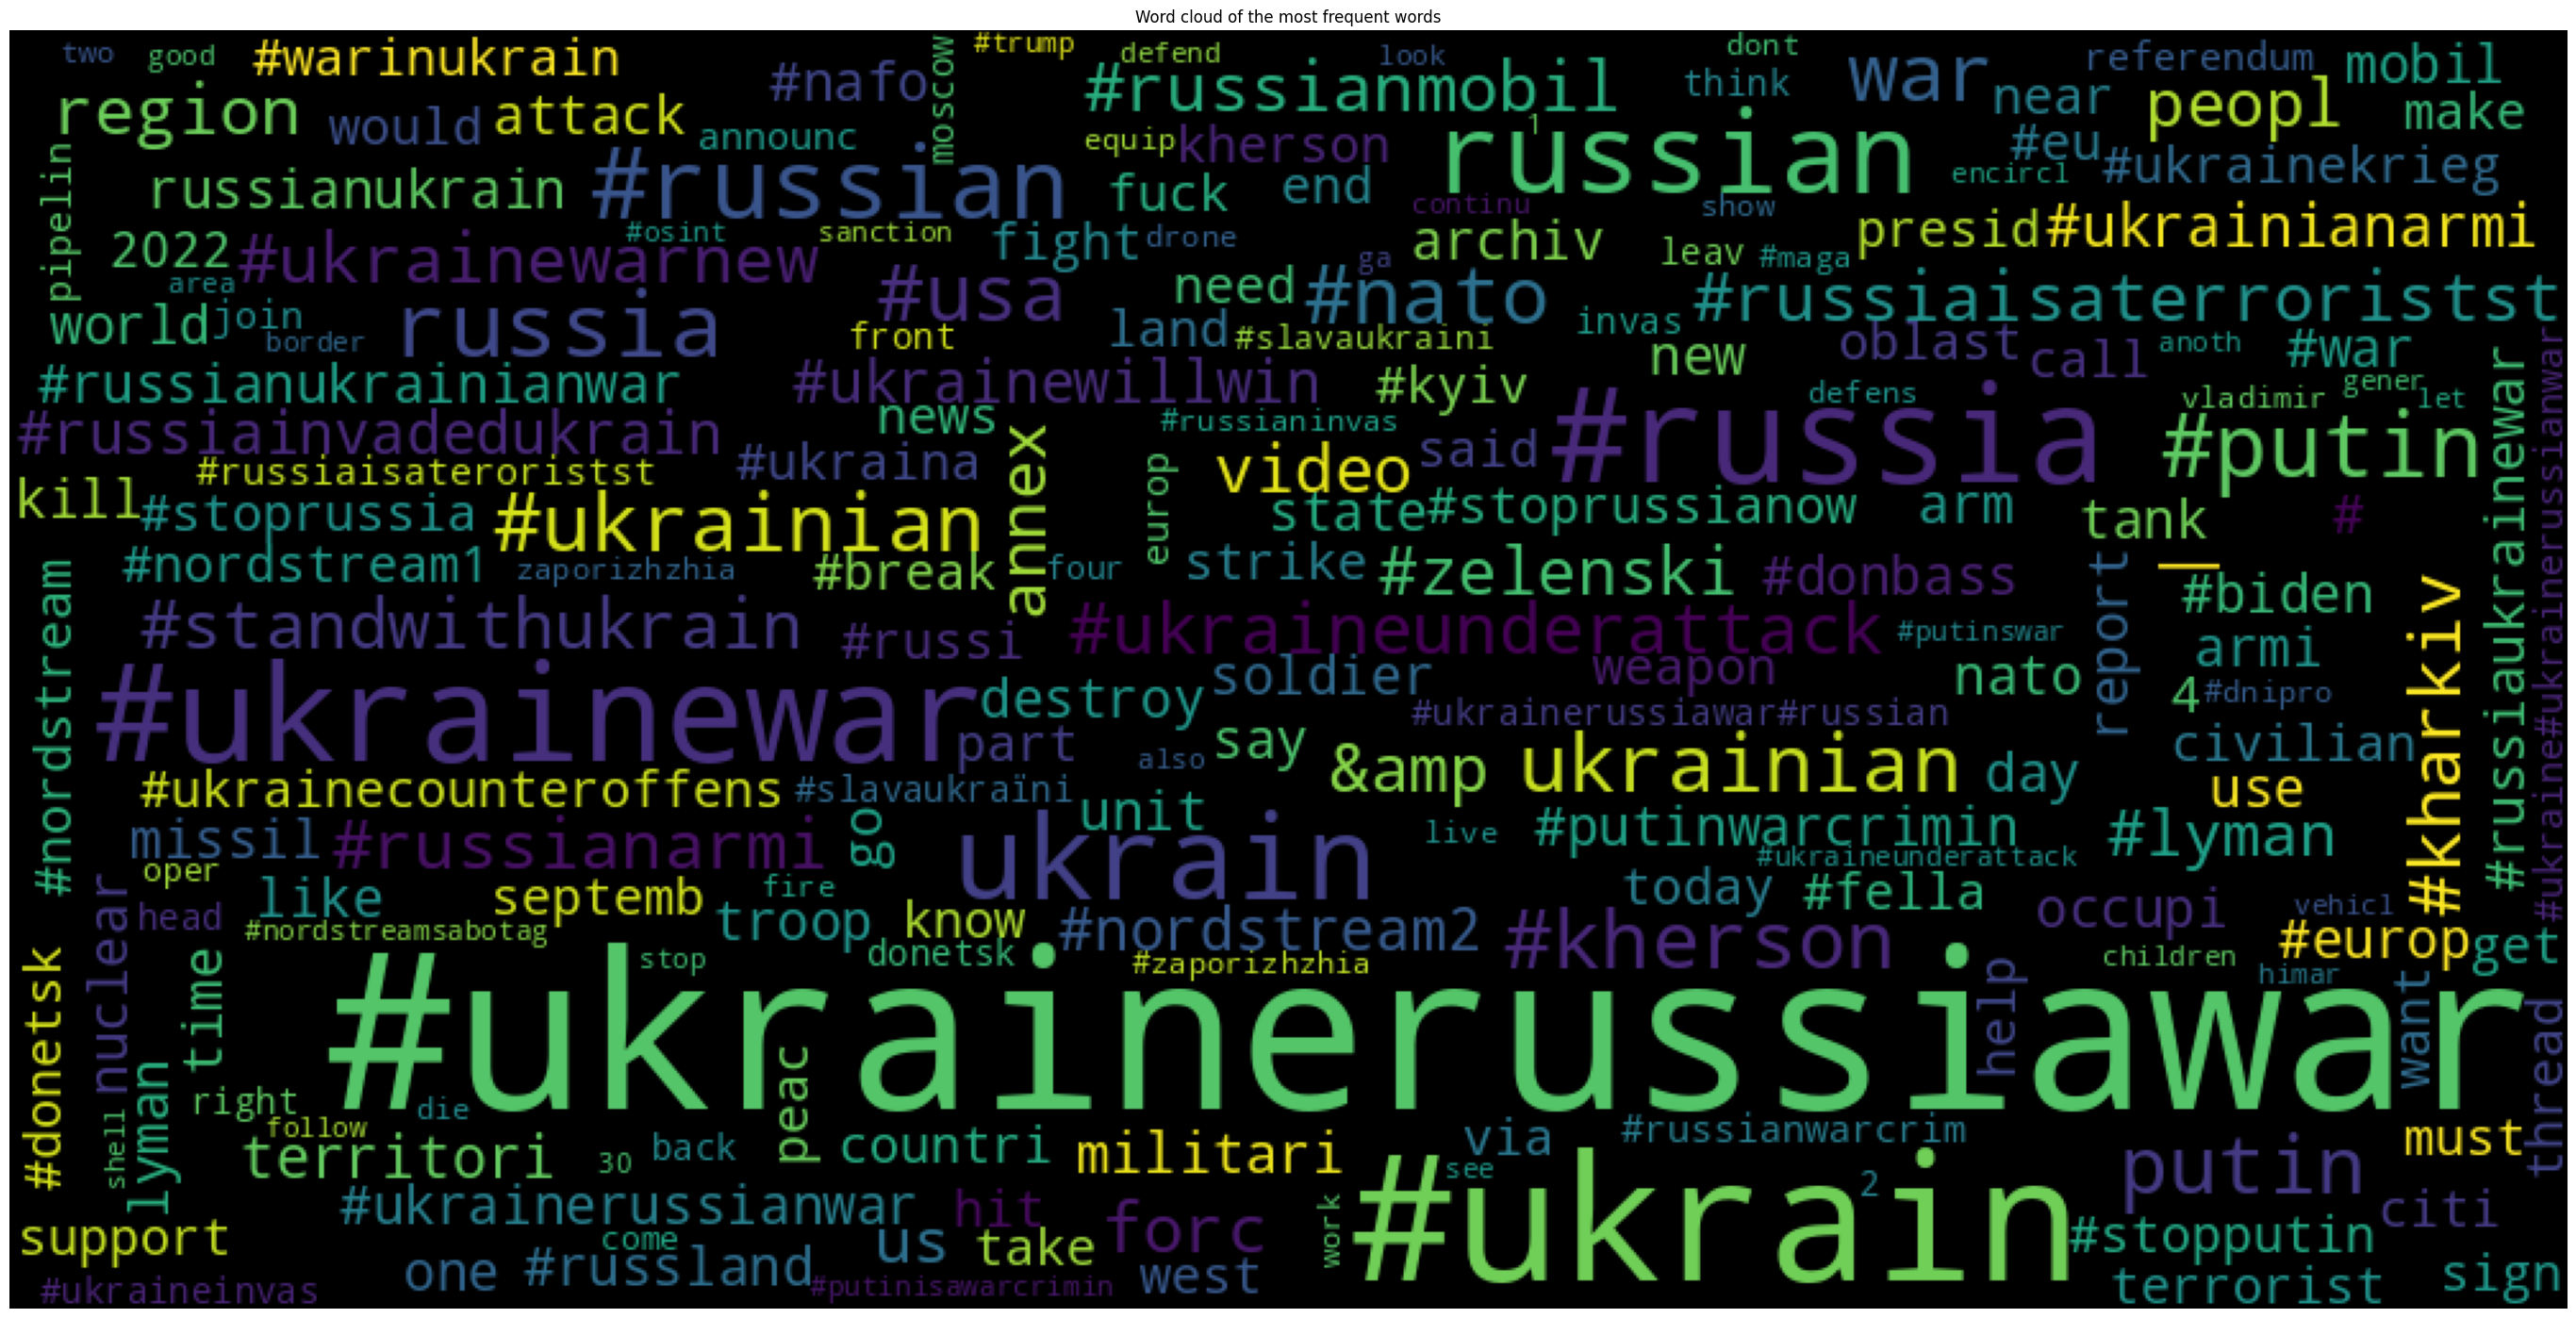

In [ ]:
# variable with a dictionary of the words count calling the function word_count for a given column of the final dataframe
word_count_dict  = word_count(df_final["full_text_tokenized"])

# function for plotting the word clouds for the most frequent words
def word_cloud(word_dict, title):
    """
    Plots a Word cloud for the most frequent words in the tweets

    Argument:
    word_dict -- dictionary of the words count
    title - title of the word cloud
    """

    # define Word Cloud object
    word_cloud = WordCloud(width=1000, height=500).generate_from_frequencies(word_dict)

    # plot
    plt.figure(figsize=(35, 20))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

word_cloud(word_count_dict, 'Word cloud of the most frequent words')

### Entity recognition

In [ ]:
# Load the pre-trained language model
lang_model = spacy.load("en_core_web_sm")

def get_entities(tweet):
    """
    Calculate the average tweet length.

    Argument:
    tokenized_sentences -- iterable with the tokens of each tweet in a list

    Returns:
    avg_length - the average length of the tweets.
    """
    # To process the tweets using a language model (spacy)
    process = lang_model(tweet)

    # Detect entities from the tweets and store them as tuples with entity and label
    entities = [(ent.text, ent.label_) for ent in process.ents]

    return entities

In [ ]:
# Apply the get_entities function to the column 'full_text' from df_final and store it in variable entities
entities = df_final['full_text'].apply(get_entities)

In [ ]:
for item in entities:
    print(item)

[('Putin', 'PERSON'), ('Fascist Russia', 'LOC'), ('Ukrainian Land', 'ORG'), ('RussiainvadesUkraine', 'ORG'), ('#UkraineRussiaWar', 'MONEY')]
[('The Armed Forces', 'ORG'), ('#UkraineWar #Ukraine️ #UkraineWillWin #', 'MONEY'), ('SlavaUkraïni', 'GPE')]
[('ALERT', 'ORG'), ('Poland', 'GPE'), ('#NATO', 'MONEY'), ('Putin', 'GPE'), ('Russia', 'GPE')]
[('Russia', 'GPE')]
[('European', 'NORP'), ('#UkraineRussiaWar', 'MONEY')]
[('Estonia', 'GPE'), ('Lithuania', 'GPE'), ('Latvia', 'GPE'), ('Ukraine', 'GPE'), ('NATO', 'ORG'), ('Lithuania', 'GPE'), ('Russia', 'GPE')]
[('NATO', 'ORG'), ('Ukraine', 'GPE'), ('Russia', 'GPE'), ('Russia', 'GPE'), ('Putin', 'GPE'), ('Ukraine', 'GPE')]
[('#UkraineRussiaWar #Ukraine', 'MONEY'), ('Russia', 'GPE'), ('OSCE', 'ORG'), ('Russia', 'GPE'), ('Ukrainian', 'NORP'), ('the Russian Federation', 'GPE'), ('Ukraine', 'GPE')]
[('Russia', 'GPE'), ('Putin', 'GPE'), ('Moscow', 'GPE'), ('Russia', 'GPE'), ('Putin', 'PERSON'), ('Russia', 'GPE'), ('Russia', 'GPE'), ('Russia', 'GPE'

In [ ]:
def group_entities(list_entitites):
    """
    Calculate the average tweet length.

    Argument:
    tokenized_sentences -- iterable with the tokens of each tweet in a list

    Returns:
    avg_length - the average length of the tweets.
    """
    # Dictionary to sotre entities grouped by their label
    entities_dict = {}

    # Loop to iterate through the list of entities
    for entity, label in list_entitites:

        # To check if the label is already in the dictionary
        if label not in entities_dict:

            # If it is not, create a new list for the label
            entities_dict[label] = []

        # To append the entity to its correct label
        entities_dict[label].append(entity)

    return entities_dict

In [ ]:
# Group the entities by their labels
grouped_entities = group_entities([entity for sublist in entities for entity in sublist])

for label, entities in grouped_entities.items():
    print(f'{label}: {entities}')

PERSON: ['Putin', 'Putin', 'Putin', 'RussiaInvadedUkraine https://t.co/bbHbocqofT', 'Putin', 'Putin', 'Lyman', 'Liman', 'Zaporizhzhia', 'Vladimir Putin', 'Crimea https://t.co/LPyiBG3q1h', 'Putin', 'Finaldn', 'nafo https://t.co/ThegpLnhiU https://t.co/SVNzXHJG2p', 'Zelensky', 'Putin', 'Biden', 'Putin', 'Mikhail Kasyanov', 'Vladimir', 'Putin', 'Caitlin Johnstone', 'tysm', '@zine_apps', 'Putin', 'Putin', 'Kherson', 'Nukes', 'Stoltenberg', 'Putin', 'https://t.co/0HQTA1Qb6b', 'Russian Msta-SM2', 'Volodymyr Zelenskiy', 'Vladimir Putin', 'Putin', 'Collective West https://t.co/KQ0CGYsoml', 'Kherson', 'Putin', 'Putin', 'Kherson', 'Zaporozhye', 'Putin', 'Putin', 'Lyman', 'Putin', 'Fellas', 'Putin', 'Putin', 'Putin', 'Putin', 'Ukrainian', 'Putin', 'Biden', 'KingdomOfGod', 'Zelensky-s', 'Lyman', 'Putin', 'Putin', 'Kherson', '@JensStoltenberg', 'putin  ', 'Krasny Liman', 'DonbassGenocide https://t.co/h7EJSfYT5d', 'Zelensky', 'Putin', 'Kyiv', 'Putin', 'Volga', 'Fellas', 'al', 'russiaisateroriststate

### Plots and graphical representations

In order to analyze the information and get a better insight into the data we are dealing with, we will use some functions to plot in a visual way the results from the functions used for the data analysis part of this project. We will start by defining a function to perform a bar plot with the top N words that have the largest number of appearances. We will take into account the result of the word-counting distribution function. Since there are a lot of words, we have considered visualizing the top N words in order to provide clearer insights

In [ ]:
def plot_top_words(word_count_dict, n):
    """
    To do a bar plot of the top N words from the word count dictionary (sorted)

    Argument:
    word_count_dict -- dictionary with the word count ordered in descending order
    n - number of top words that will be plotted

    Returns:
    Nothing

    """
    # Transform the word count dictionary into a list of tuples
    word_count_ordered = list(word_count_dict.items())

    # Check that n does not exceed the available words
    if n > len(word_count_ordered):
        n = len(word_count_ordered)

    # Get the top N words and their counts from the ordered list of word count
    top_n_words = [item[0] for item in word_count_ordered[:n]]
    top_n_count = [item[1] for item in word_count_ordered[:n]]

    # To create the bar plot
    plt.figure(figsize=(18, 10))
    plt.bar(range(n), top_n_count, tick_label=top_n_words)
    plt.xlabel("Words", fontsize=18)
    plt.ylabel("Count", fontsize=18)
    plt.title(f"Top {n} Word Count Distribution", fontsize=22)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(rotation=60)
    plt.show()

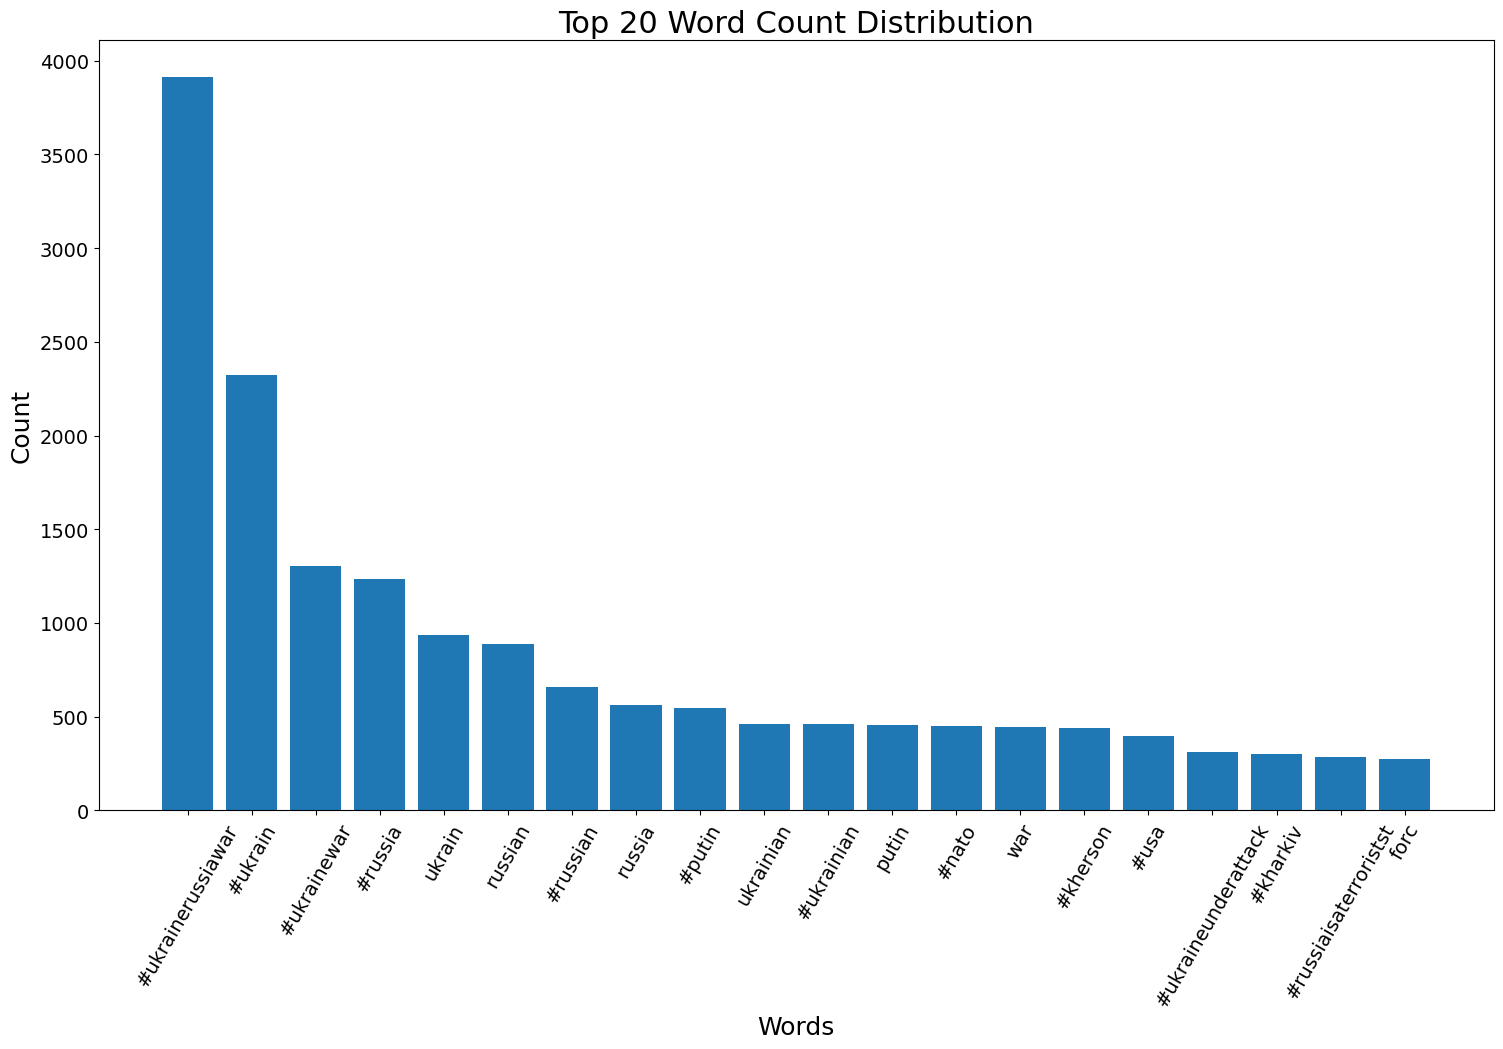

In [ ]:
dict_word_count_ordered = order_word_count(word_count_dict)
plot_top_words(dict_word_count_ordered, 20)

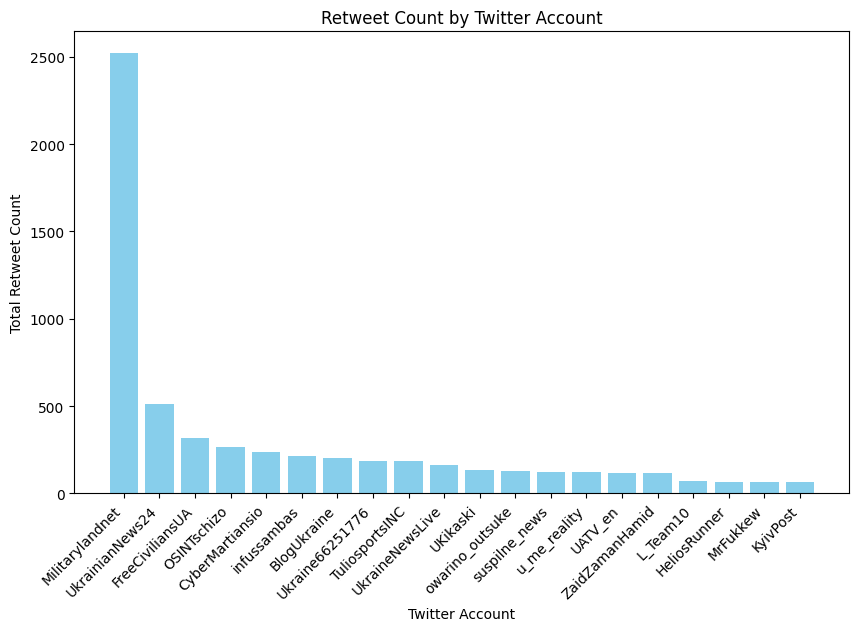

In [ ]:
from collections import Counter

def extract_account_from_tweet(tweet_url):
    """
    Get the name of the Twitter account form the url

    Argument:
    tweet_url -- the url from the tweet

    Returns:
    parts[3] - the name of the twitter account
    """
    # to split the url of the tweet and store them in a list
    parts = tweet_url.split('/')

    # check the length of the list
    if len(parts) >= 4:

        # if true, return element in index 3 (twitter account)
        return parts[3]
    else:
        return None

def plot_ranking(rank_tweets):
    """
    To plot the Retweet Count grouped by accounts

    Argument:
    rank_tweets -- the list of the ranking of the tweets most retweeted

    Returns:
    account_counts - dictionary containing the accumulated count of the retweets for the twitter accounts
    """
    account_counts = Counter()

    #Iterate thorugh every tweet
    for tweet in rank_tweets:
        tweet_url = tweet['tweet']
        account = extract_account_from_tweet(tweet_url)
        #If the account is already saved we increase its number of retweets
        if account:
            account_counts[account] += tweet['retweet_count']

    # Sort the accounts by the retweet count
    sorted_accounts = sorted(account_counts.items(), key=lambda x: x[1], reverse=True)

    # Extract account names and retweet
    accounts, retweet_counts = zip(*sorted_accounts)

    # To create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(accounts[:20], retweet_counts[:20], color='skyblue')
    plt.xlabel('Twitter Account')
    plt.ylabel('Total Retweet Count')
    plt.title('Retweet Count by Twitter Account')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.show()
    return account_counts


account_counts = plot_ranking(ranked_tweets)
